<span style="color:red">Warning:</span> this notebook is outdated and does not serve a purpose anymore. We still include it in the submission to show our complete work. We used this for our first attempts of inferencing with BEit3.

In [1]:
%pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
%pip install transformers
%pip install timm
%pip install sentencepiece
%pip install torchscale
%pip install torchsummary

Looking in indexes: https://download.pytorch.org/whl/cu121, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.


In [81]:
import pandas as pd
import torch
import os
from transformers import XLMRobertaTokenizer
from loading_beit3models import load_beit3_large
from Beit3_vizwiz import VizWizDataset, get_img_names_and_questions, create_vqav2_label2ans_ans2label
from transformers import BatchEncoding, XLMRobertaTokenizer
import torch
import torchvision.transforms as transforms
import torch.nn as nn
from timm.data.constants import IMAGENET_INCEPTION_MEAN, IMAGENET_INCEPTION_STD
from torch.utils.data import DataLoader, Dataset
import json
from tqdm import tqdm

In [82]:
tokenizer = XLMRobertaTokenizer("./models/beit3.spm")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = load_beit3_large()

In [8]:
# freeze all parameters instead of the head
for name, value in model.named_parameters():
    if not "head" in name:
        value.requires_grad = False

In [56]:
import json
from collections import Counter

def create_vizwiz_label2ans_ans2label(data_dir: str):
    answers = []
    data_sets = ["train", "val"]
    for data_set in data_sets:
        with open(f"{data_dir}/{data_set}.json", "r", encoding="utf-8") as f:
            data = json.load(f)
            for d in data:
                for a in d["answers"]:
                    answers.append(a["answer"])

    answers = Counter(answers)
    answers = answers.most_common(3129)
    label2ans = [a for (a, _) in answers]
    ans2label = {answer: i for i, answer in enumerate(label2ans)}
    return ans2label, label2ans

viz_wiz_ans2label, viz_wiz_label2ans = create_vizwiz_label2ans_ans2label("../VizWizAnnotations")

In [57]:
tokenizer = XLMRobertaTokenizer("./models/beit3.spm")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_img_names, train_questions, train_ans = get_img_names_and_questions(data_dir="../VizWizAnnotations/", split='train')
ans2label, label2ans = create_vqav2_label2ans_ans2label()

INPUT_SIZE = 480

transform = transforms.Compose(
    [
        transforms.Resize((INPUT_SIZE, INPUT_SIZE), interpolation=3),
        transforms.ToTensor(),
        transforms.Normalize(mean=IMAGENET_INCEPTION_MEAN, std=IMAGENET_INCEPTION_STD),
    ]
)

In [91]:
split = "val"
def getData(use_coco_labels=False):
    with open(os.path.join("./VizWiz/VizWizAnnotations/", f"{split}.json"), "r", encoding="utf-8") as f:
        data = json.load(f)
        img_names = list()
        questions = list()
        ans = list()
        for d in data:
            answers = [answer["answer"] for answer in d["answers"]]
            top_answer = Counter(answers).most_common(1)[0]
            use_data = False

            if use_coco_labels:
                if ans2label.get(top_answer[0]) is not None or top_answer[0] == "unanswerable":
                    use_data = True
                # use_data = ans2label.get(top_answer[0]) is not None
            else:
                use_data = viz_wiz_ans2label.get(top_answer[0]) is not None

            if use_data:
                img_names.append(d["image"])
                questions.append(d["question"])
                ans.append(top_answer[0])
        return img_names, questions, ans, len(data)

# if we use the most common COCO labels, we can only answer 6.309/20.523 (≈ 68%) questions in train set and 3.040/4.319 (≈ 70%) in val set
# if we use the most common VizwWiz labels, we can answer 17.525/20.523 (≈ 85%) questions in train set and 3.697/4.319 (≈ 86%) in val set
img_names, questions, ans, inital_length = getData(True)

In [92]:
len(img_names), inital_length

(3040, 4319)

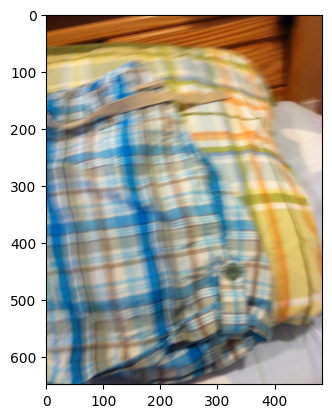

In [22]:
import requests
import matplotlib.pyplot as plt
from PIL import Image
# coco
url = 'https://farm6.staticflickr.com/5185/5577338146_c89a45bfc0_z.jpg'
# vizwiz
img_name = "VizWiz_val_00003814.jpg"
url = f"https://vizwiz.cs.colorado.edu/VizWiz_visualization_img/{img_name}"
image = Image.open(requests.get(url, stream=True).raw)
plt.imshow(image)

In [20]:
from transformers import ViltProcessor, ViltForQuestionAnswering

processor = ViltProcessor.from_pretrained("dandelin/vilt-b32-finetuned-vqa")
model = ViltForQuestionAnswering.from_pretrained("dandelin/vilt-b32-finetuned-vqa")

question = "What is this?"
encoding = processor(image, question, return_tensors="pt")

outputs = model(**encoding)
logits = outputs.logits
idx = logits.argmax(-1).item()
print("Predicted answer:", model.config.id2label[idx])

Predicted answer: shirt
